In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os
import json
from collections import OrderedDict
import tensorflow as tf
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import emcee

In [6]:
from agnfinder.tf_sampling import deep_emulator, api, run_sampler
from agnfinder.tf_sampling.api import SamplingProblem
from agnfinder.tf_sampling.hmc import SamplerHMC
from agnfinder import simulation_utils, simulation_samples
from agnfinder.prospector import visualise, main, cpz_builders

Using TensorFlow backend.


In [3]:
os.chdir('/home/mike/repos/agnfinder')

In [4]:
catalog_loc = '/media/mike/beta/agnfinder/cpz_paper_sample_week3_maggies.parquet'
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0., 2.],  # not age of universe, as mistakenly done before...
    'tage': [0.001, 13.8],  # not 0->2, as mistakenly done before...might consider bringing the bounds a bit tighter
    'log_tau': [np.log10(.1), np.log10(30)],  # careful, this is log prior! >2, has very little effect
    'log_agn_mass': [-7, np.log10(15)],  # i.e. from 10**-7 to 15 (not 10**15!)
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})

In [7]:
forward_model, wavelengths = simulation_samples.get_forward_model(catalog_loc, emulate_ssp=False, noise=False)

[<class 'sedpy.observate.Filter'>(u_sloan), <class 'sedpy.observate.Filter'>(g_sloan), <class 'sedpy.observate.Filter'>(r_sloan), <class 'sedpy.observate.Filter'>(i_sloan), <class 'sedpy.observate.Filter'>(z_sloan), <class 'sedpy.observate.Filter'>(VISTA_H), <class 'sedpy.observate.Filter'>(VISTA_J), <class 'sedpy.observate.Filter'>(VISTA_Ks), <class 'sedpy.observate.Filter'>(VISTA_Y), <class 'sedpy.observate.Filter'>(VISTA_Z), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2)]


In [11]:
_, _, x_test, y_test = deep_emulator.data()
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [68]:
galaxy_n = 10
true_params = x_test[galaxy_n]
true_observation = deep_emulator.denormalise_photometry(y_test[galaxy_n])

In [99]:
def get_python_log_prob_fn(fsps_forward_model, true_observation):
    def log_prob_fn(x):
        if x.max() > 1. or x.min() < 0.:
            return -np.inf
        denormalised_x = simulation_utils.denormalise_hypercube(x.reshape(1, 7), free_params)
        expected_photometry = fsps_forward_model(denormalised_x.squeeze())
        deviation = np.abs(expected_photometry - true_observation)
        sigma = expected_photometry * 0.05  # i.e. 5% sigma, will read in soon-ish
        log_prob = -np.sum(deviation / sigma)
        return log_prob
    return log_prob_fn


In [107]:
log_prob_fn = get_python_log_prob_fn(forward_model, true_observation)

In [108]:
nwalkers = 50
ndim = 7

In [109]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn)

In [110]:
p0 = np.random.uniform(low=0, high=1, size=(nwalkers, ndim))
# p0 = np.array([true_params for n in range(nwalkers)])

In [111]:
p0.shape

(50, 7)

In [118]:
state = sampler.run_mcmc(p0, 100)

In [119]:
# sampler.acceptance_fraction

array([0.01818182, 0.12727273, 0.27272727, 0.21818182, 0.29090909,
       0.32727273, 0.2       , 0.25454545, 0.29090909, 0.25454545,
       0.36363636, 0.36363636, 0.30909091, 0.30909091, 0.25454545,
       0.29090909, 0.30909091, 0.05454545, 0.27272727, 0.07272727,
       0.29090909, 0.27272727, 0.27272727, 0.27272727, 0.21818182,
       0.41818182, 0.32727273, 0.30909091, 0.45454545, 0.36363636,
       0.2       , 0.30909091, 0.21818182, 0.32727273, 0.23636364,
       0.29090909, 0.2       , 0.34545455, 0.25454545, 0.41818182,
       0.30909091, 0.36363636, 0.36363636, 0.34545455, 0.30909091,
       0.30909091, 0.23636364, 0.36363636, 0.38181818, 0.30909091])

In [ ]:
sampler.reset()

In [120]:
state = sampler.run_mcmc(state, 1000)

In [121]:
samples = sampler.get_chain(flat=True)

In [122]:
samples.shape

(27750, 7)

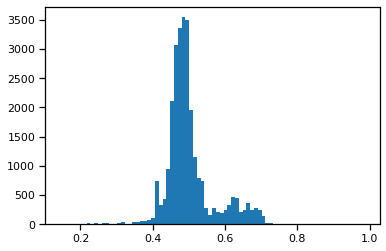

In [123]:
_ = plt.hist(samples[:, 0])

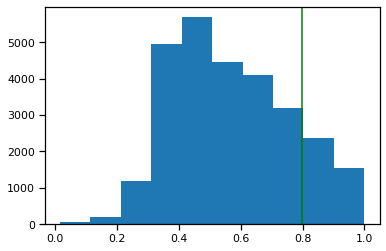

In [126]:
_ = plt.hist(samples[:, 2])
plt.axvline(true_params[2], color='g')